In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from skimage import io
from glob import glob
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
)
from sklearn.model_selection import train_test_split

from modules.utility.path import DATA_PATH
from modules.image_data_generator import train_generator
from modules.unet_with_resnet import BCDU_net_D3
from modules.metrik import (
    dice_coef, dice_coef_loss, bce_dice_loss, iou
)

## Data Preparation

In [2]:
df = pd.read_csv("data/data_path.csv")
df.head()

,image_path,mask_path,mask
0,c:\Users\Dicoding\Documents\my-project\skin-ca...,c:\Users\Dicoding\Documents\my-project\skin-ca...,1
1,c:\Users\Dicoding\Documents\my-project\skin-ca...,c:\Users\Dicoding\Documents\my-project\skin-ca...,1
2,c:\Users\Dicoding\Documents\my-project\skin-ca...,c:\Users\Dicoding\Documents\my-project\skin-ca...,1
3,c:\Users\Dicoding\Documents\my-project\skin-ca...,c:\Users\Dicoding\Documents\my-project\skin-ca...,1
4,c:\Users\Dicoding\Documents\my-project\skin-ca...,c:\Users\Dicoding\Documents\my-project\skin-ca...,1


In [3]:
# im_width = 256
# im_height = 256

# image_files = []
# mask_files = glob(DATA_PATH+'\\masks*\\*_segmentation*')

# for i in mask_files:
#     image_files.append(i.replace('_segmentation','').replace('\\masks', '\\images').replace('.png','.jpg'))


In [4]:
# df = pd.DataFrame({"image_path": image_files, "mask_path":mask_files})

# def diagnosis(mask_path):
#     value = np.max(cv2.imread(mask_path))
#     if value:
#         return 1
#     else:
#         return 0

# df['mask'] = df["mask_path"].apply(lambda x: diagnosis(x))
# df.head()

In [5]:
# df.to_csv('data/data_path.csv', index=False)

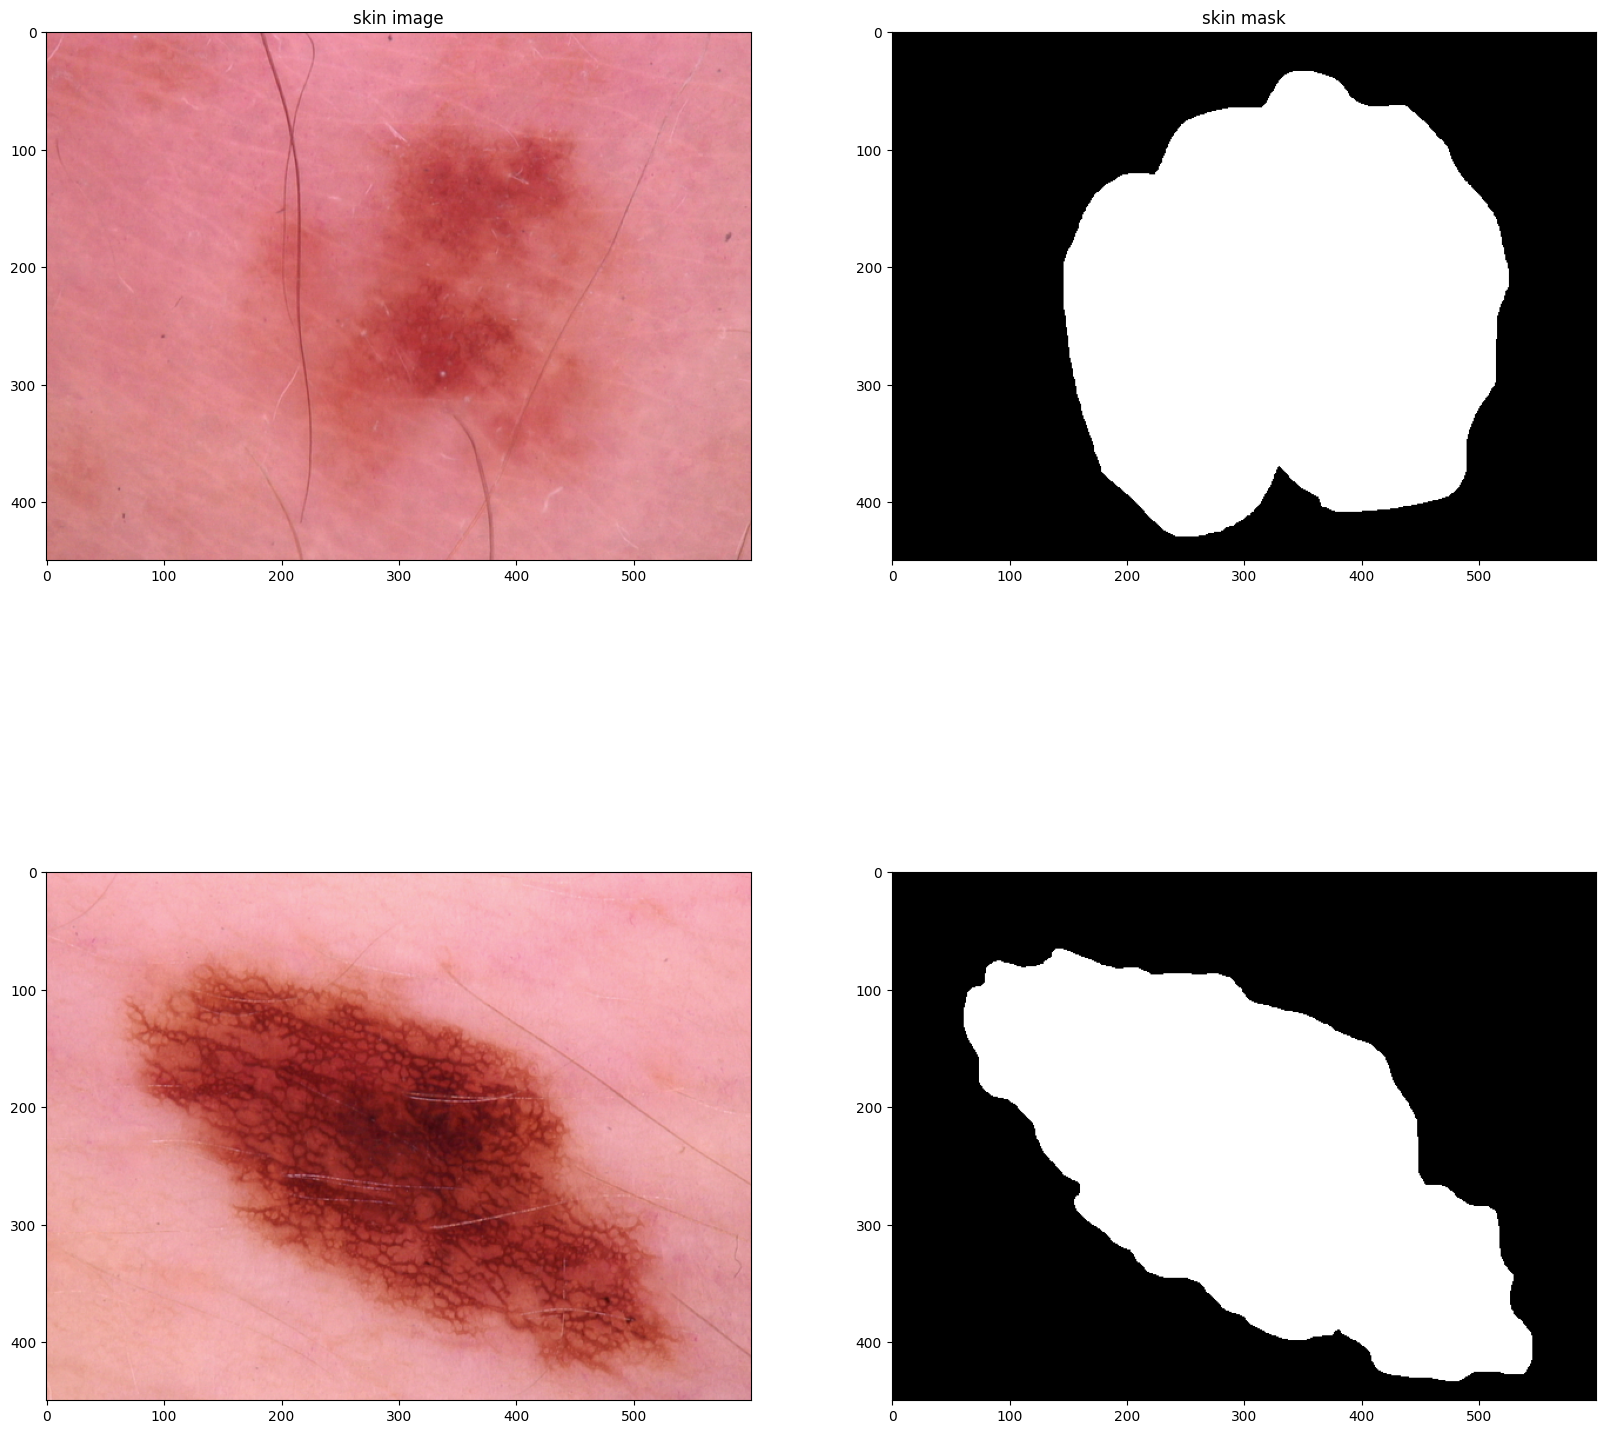

In [6]:

image1 = io.imread(df.image_path[1])

image2 = io.imread(df.image_path[2])

# Show masks
mask1 = io.imread(df.mask_path[1])
mask2 = io.imread(df.mask_path[2])


f, axarr = plt.subplots(2,2,figsize=(20, 20))
axarr[0,0].imshow(image1)
axarr[0,0].title.set_text("skin image")
axarr[0,1].imshow(mask1,cmap='gray')
axarr[0,1].title.set_text("skin mask")
matplotlib.rcParams.update({'font.size': 22})
axarr[1,0].imshow(image2)
axarr[1,1].imshow(mask2,cmap='gray')

In [7]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(7235, 3)
(1277, 3)
(1503, 3)


In [8]:
IMAGE_SIZE = (256, 256)

c:\Users\Dicoding\anaconda3\envs\skin-cancer\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


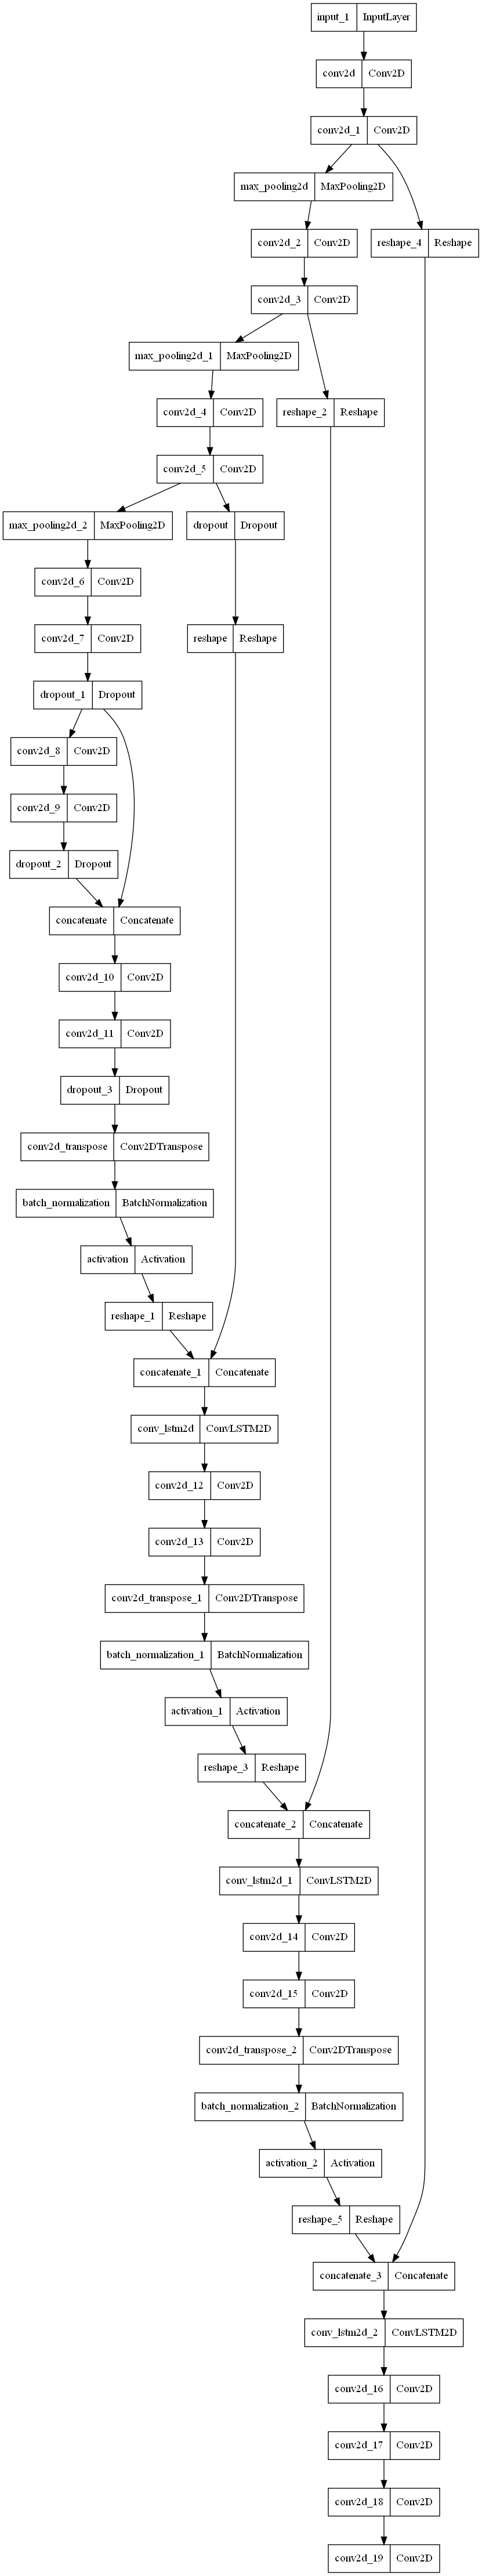

In [9]:
model = BCDU_net_D3((256,256,3))
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [11]:
EPOCHS = 3
BATCH_SIZE = 32
learning_rate = 0.5e-3

In [12]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])

callbacks = [ModelCheckpoint('models/RESUNET1_skin_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 7235 validated image filenames.
Found 7235 validated image filenames.
Epoch 1/3


c:\Users\Dicoding\anaconda3\envs\skin-cancer\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  9/226 [>.............................] - ETA: 8:32:43 - loss: 1.3404 - iou: 0.2020 - dice_coef: 0.3358

In [ ]:
model.save("models/unet-resnet-model.h5")